# End-To-End Training Example of RNN for rain estimation and detection using PyNNCML
This notebook presents an end-to-end example of training a Recurrent Neural Network (RNN) based rain estimation neural network [1] on the openMRG dataset[2].
This tutorial is built using the PyNNCML software package, which provides both tools to simplify the training process of deep learning models for CMLs.
We start with obtaining a subset of the OpenMRG dataset and splitting it into training and validation datasets.
Afterward, we construct the One Step Network from [1], followed by the training loop.
Finally, we analyze the model performance in terms of RMSE and Bias.


Notebook structure
1. Imports and Installation of PyNNCML
2. Hyperparameter settings
3. Build Dataset
4. Build Neural Network
5. Training Loop
6. Neural Network Analysis


[Run this notebook in colab](https://colab.research.google.com/github/haihabi/PyNNcml/blob/main/examples/tutorials/data_driven_tutorial.ipynb)

To run this notebook on Colab using GPU, please do the following:
Runtime -> Change runtime type -> Select GPU -> Save


In [1]:
import sys
import os

if os.path.exists('../../pynncml'):
    print("Import PyNNCML From Code")
    sys.path.append('../../')  # This line is need to import pynncml
else:
    print("Install PyNNCML From pip")
    !pip install pynncml

import numpy as np
import pynncml as pnc
import torch
import math
from matplotlib import pyplot as plt
from tqdm import tqdm
import scipy
from sklearn import metrics


Import PyNNCML From Code


/data/envs/research/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hyper-Parameters

In [2]:
#  @title Hyper-parameters
batch_size = 16  # @param{type:"integer"}
window_size = 32  # @param{type:"integer"}
rnn_n_features = 128  # @param{type:"integer"}
metadata_n_features = 32  # @param{type:"integer"}
n_layers = 2  # @param{type:"integer"}
lr = 1e-4  # @param{type:"number"}
weight_decay = 1e-4  # @param{type:"number"}
rnn_type = pnc.neural_networks.DNNType.GRU  # RNN Type
n_epochs = 200  # @param{type:"integer"}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Building Training and Validation datasets

In [3]:
time_slice = slice("2015-06-01", "2015-06-10")  # Time Interval
dataset = pnc.datasets.loader_open_mrg_dataset(time_slice=time_slice)

File already exists at desired location ./data/OpenMRG.zip
Not downloading!


100%|██████████| 728/728 [00:09<00:00, 78.69it/s] 


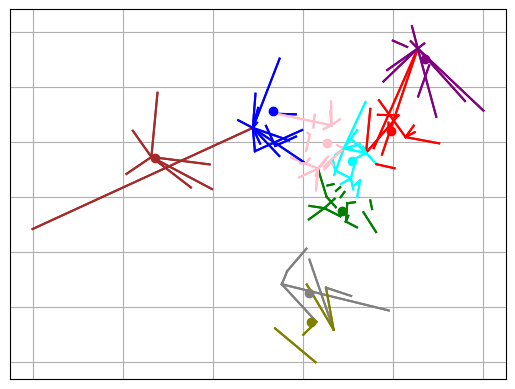

In [4]:
dataset.link_set.plot_links(scale=True, scale_factor=1.0)
plt.grid()
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()

In [5]:
training_dataset, validation_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
data_loader = torch.utils.data.DataLoader(training_dataset, batch_size)
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size)

# Compute rain rate statistics
In this section, we compute the rain rate statistics of the dataset. The rain rate statistics are used to understand the distribution of the rain rate in the dataset.
In addition we estimate the parameters of the exponential distribution that fits the rain rate data that will be utilized in later stage to compute a balanced loss function.


Rain Rate Statistics
Mean[mm/hr]: 0.12803642582835345
Std[mm/hr]: 0.6123836062324627
Parentage of wet samples 10.171653908605892
Parentage of dry samples 89.82834609139411
Exponential Distribution Parameters: (0.0, 0.12803642582835345)


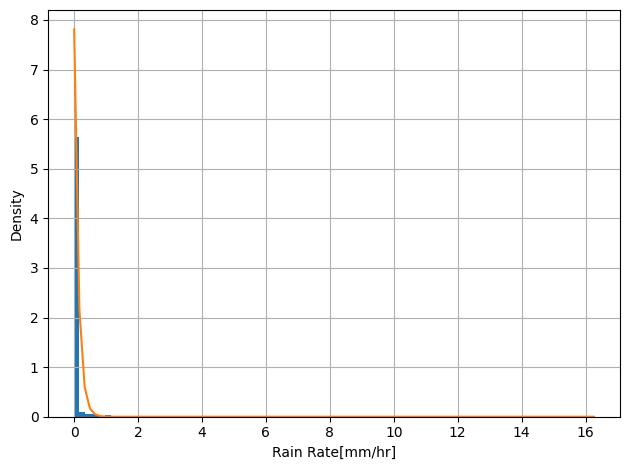

In [6]:
rg = np.stack([p.data_array for p in dataset.point_set]).flatten()
param = scipy.stats.expon.fit(rg)
exp_gamma = param[1]
print("Rain Rate Statistics")
print("Mean[mm/hr]:", np.mean(rg))
print("Std[mm/hr]:", np.std(rg))
print("Parentage of wet samples", 100 * np.sum(rg > 0) / rg.size)
print("Parentage of dry samples", 100 * np.sum(rg == 0) / rg.size)
print("Exponential Distribution Parameters:", param)
_ = plt.hist(rg, bins=100, density=True)
plt.plot(np.linspace(0, np.max(rg), 100), scipy.stats.expon.pdf(np.linspace(0, np.max(rg), 100), *param))
plt.grid()
plt.xlabel("Rain Rate[mm/hr]")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


# Neural Network

The neural network is constructed using the PyTorch library. The network consists of two main components: <br>
1. RNN: A recurrent neural network that takes the CML signal and the metadata as input and outputs the rain rate. <br>
2. Metadata: A fully connected layer that takes the metadata as input and outputs a feature vector. <br>
The RNN is trained to predict the rain rate at each time step based on the CML signal and the metadata. <br>
3. The network architecture is shown in the figure below: <br>
![Alt text](https://raw.githubusercontent.com//haihabi/PyNNcml/main/images/two_step_network.png )


The network consists of the following components:<br>
1. A backbone that is built of RNN layers that process the CML attenuation and the metadata (shown in blue). <br>
2. A wet/dry classifier that is built of fully connected layers that process backbone feature and produce wet/dry prediction (shown in red). <br>
3. A rain rate estimator that is built of fully connected layers that process backbone feature and produce rain rate prediction (shown in green). <br>






In [7]:
model = pnc.scm.rain_estimation.two_step_network(n_layers=n_layers,  # Number of RNN layers
                                                 rnn_type=rnn_type,  # Type of RNN (GRU, LSTM)
                                                 normalization_cfg=pnc.training_helpers.compute_data_normalization(
                                                     data_loader),
                                                 # Compute the normalization statistics from the training dataset.
                                                 rnn_input_size=180,  # 90 + 90 (RSL + TSL)
                                                 rnn_n_features=rnn_n_features,  # Number of features in the RNN
                                                 metadata_input_size=2,  # Number of metadata features
                                                 metadata_n_features=metadata_n_features,
                                                 # Number of features in the metadata
                                                 pretrained=False).to(
    device)  # Pretrained model is set to False to train the model from scratch.



The loss function used to train the rain estimation model is as follows:
$$J(\Theta)=J_{\mathrm{BCE}}+\lambda J_{\mathrm{Reg}},$$
where $J_{\mathrm{BCE}}$ is a binary cross entropy loss and
$$J_{\mathrm{Reg}}=\frac{1}{N_b}\sum_{i=1}^{N_b}\sum_{j=1}^{N_s}(1-\gamma_s\exp(-\gamma \cdot r_{i,j}))\cdot(\hat{r}_{i,j}-r_{i,j})^2,$$
is the regression loss function.


In [8]:
class RegressionLoss(torch.nn.Module):
    def __init__(self, in_gamma, gamma_s=0.9):
        super(RegressionLoss, self).__init__()
        self.in_gamma = in_gamma
        self.gamma_s = gamma_s

    def forward(self, input, target):
        delta = (target - input) ** 2
        w = 1 - self.gamma_s * torch.exp(-self.in_gamma * target)
        return torch.sum(torch.mean(w * delta, dim=0))


loss_function_rain_est = RegressionLoss(exp_gamma)
loss_function_wet_dry = torch.nn.BCELoss()

# Find lambda values such that at initialization both loss will be equal:
loss_est = 0
loss_detection = 0
with torch.no_grad():
    for rain_rate, rsl, tsl, metadata in data_loader:
        state = model.init_state(batch_size=rsl.shape[0])
        m_step = math.floor(rain_rate.shape[1] / window_size)
        for step in range(m_step):
            _rr = rain_rate[:, step * window_size:(step + 1) * window_size,0].float().to(device)
            _rsl = rsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            _tsl = tsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            rain_estimation_detection, state = model(torch.cat([_rsl, _tsl], dim=-1), metadata.to(device),
                                                     state.detach())
            rain_hat = rain_estimation_detection[:, :, 0]
            rain_detection = rain_estimation_detection[:, :, 1]
            loss_est += loss_function_rain_est(rain_hat, _rr)
            loss_detection += loss_function_wet_dry(rain_detection, (_rr > 0.1).float())
lambda_value = loss_detection / loss_est

# Training Loop

The training loop consists of the following steps:
1. Initialize the optimizer and loss function: <br>
    a. Optimizer: We use the RAdam optimizer with a learning rate of 1e-4 and a weight decay of 1e-4. <br>
    b. Loss Function: We use the Mean Squared Error (MSE) loss function to compute the loss. <br>
2. Iterate over the training dataset and compute the loss. <br>
3. Update the model parameters using the optimizer. <br>
4. Compute the average loss over the training dataset.  <br>
5. Repeat the process for a fixed number of epochs. 

In [9]:
opt = torch.optim.RAdam(model.parameters(), lr=lr, weight_decay=weight_decay)
ra = pnc.metrics.ResultsAccumulator()
am = pnc.metrics.AverageMetric()

model.train()
print("Start Training")
for epoch in tqdm(range(n_epochs)):
    am.clear()
    for rain_rate, rsl, tsl, metadata in data_loader:
        state = model.init_state(batch_size=rsl.shape[0])
        m_step = math.floor(rain_rate.shape[1] / window_size)
        for step in range(m_step):
            opt.zero_grad()  # Zero gradients
            # Perform sliding window in the CML time series.  
            _rr = rain_rate[:, step * window_size:(step + 1) * window_size,0].float().to(device)
            _rsl = rsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            _tsl = tsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            # Forward pass of the model
            rain_estimation_detection, state = model(torch.cat([_rsl, _tsl], dim=-1), metadata.to(device),
                                                     state.detach())
            rain_hat = rain_estimation_detection[:, :, 0]
            rain_detection = rain_estimation_detection[:, :, 1]
            # Compute loss function
            loss_est = loss_function_rain_est(rain_hat, _rr)
            loss_detection = loss_function_wet_dry(rain_detection, (_rr > 0.1).float())
            loss = lambda_value * loss_est + loss_detection
            # Take the derivative w.r.t. model parameters $\Theta$
            loss.backward()
            opt.step()
            am.add_results(loss=loss.item(), loss_est=loss_est.item(),
                           loss_detection=loss_detection.item())  # Log results to average.
    ra.add_results(loss=am.get_results("loss"), loss_est=am.get_results("loss_est"),
                   loss_detection=am.get_results("loss_detection"))

Start Training


100%|██████████| 200/200 [02:15<00:00,  1.48it/s]


# Analysis of training progress
Here, we plot loss of the model during optimization. 

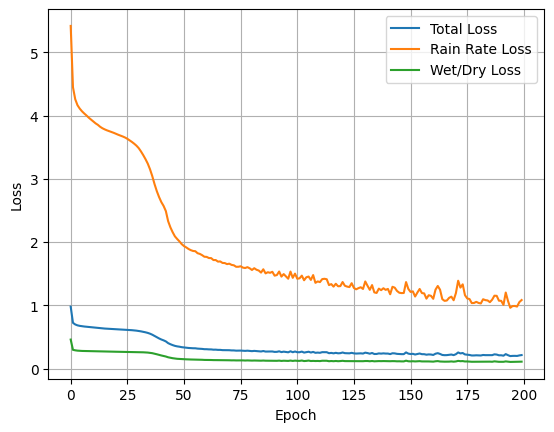

In [10]:
plt.plot(ra.get_results("loss"), label="Total Loss")
plt.plot(ra.get_results("loss_est"), label="Rain Rate Loss")
plt.plot(ra.get_results("loss_detection"), label="Wet/Dry Loss")
plt.grid()
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Model Validation
In this section we validate the neural network quality on the validation datasets. First we provide a statistical results of the trained model which include:
1. Estimation Bias
2. Estimation RMSE
3. Accuracy of Detection
4. Confusion Matrix
5. F1 Score


Secondly we provide some visualization to analyze the model performance. 

 

Results Detection:
Validation Results of Two-Step RNN
Accuracy[%]: 96.50862068965517
F1 Score: 0.7915057915057915


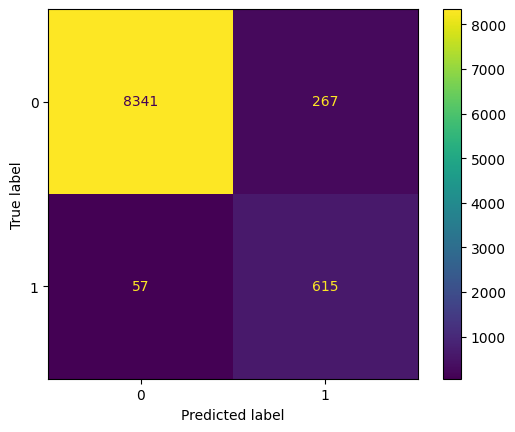

Results Estimation:
-------------------------------------------------- Results Summery --------------------------------------------------
+--------------+------------+--------------------------+---------------------------------------+----------------------------------------+-----------------------------------------+
|    Metric    | 0.0<r<3.25 | 3.25<r<6.510000228881836 | 6.510000228881836<r<9.760000228881836 | 9.760000228881836<r<13.010000228881836 | 13.010000228881836<r<16.260000228881836 |
+--------------+------------+--------------------------+---------------------------------------+----------------------------------------+-----------------------------------------+
|     RMSE     |    0.24    |           2.24           |                  4.23                 |                  8.5                   |                  14.55                  |
|     BIAS     |   -0.02    |           1.48           |                  3.83                 |                  8.46                  |     

In [11]:
model.eval()
ga = pnc.metrics.GroupAnalysis()
with torch.no_grad():
    for rain_rate, rsl, tsl, metadata in val_loader:
        state = model.init_state(batch_size=rsl.shape[0])
        m_step = math.floor(rain_rate.shape[1] / window_size)
        am.clear()
        rain_ref_list = []
        rain_hat_list = []
        detection_list = []

        for step in range(m_step):
            _rr = rain_rate[:, step * window_size:(step + 1) * window_size,0].float().to(device)
            _rsl = rsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            _tsl = tsl[:, step * window_size:(step + 1) * window_size, :].to(device)
            rain_estimation_detection, state = model(torch.cat([_rsl, _tsl], dim=-1), metadata.to(device),
                                                     state.detach())
            rain_detection = rain_estimation_detection[:, :, 1]
            rain_hat = rain_estimation_detection[:, :, 0] * torch.round(
                rain_detection)  # Rain Rate is computed only for wet samples
            rain_hat_list.append(rain_hat.detach().cpu().numpy())
            rain_ref_list.append(_rr.detach().cpu().numpy())
            ga.append(rain_ref_list[-1], rain_hat_list[-1])
            detection_list.append(torch.round(rain_detection).detach().cpu().numpy())
            delta = rain_hat.squeeze(dim=-1) - _rr
            bias = torch.mean(delta)
            mse = torch.mean(delta ** 2)
            am.add_results(bias=bias.item(), mse=mse.item())
actual = np.concatenate(detection_list).flatten()
predicted = (np.concatenate(rain_ref_list) > 0.1).astype("float").flatten()
confusion_matrix = metrics.confusion_matrix(actual, predicted)
max_rain = np.max(np.concatenate(rain_ref_list))
g_array = np.linspace(0, max_rain, 6)

print("Results Detection:")
print("Validation Results of Two-Step RNN")
print("Accuracy[%]:", 100 * (np.sum(actual == predicted) / actual.size))
print("F1 Score:", metrics.f1_score(actual, predicted))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])

cm_display.plot()
plt.show()

print("Results Estimation:")
_ = ga.run_analysis(np.stack([g_array[:-1], g_array[1:]], axis=-1))


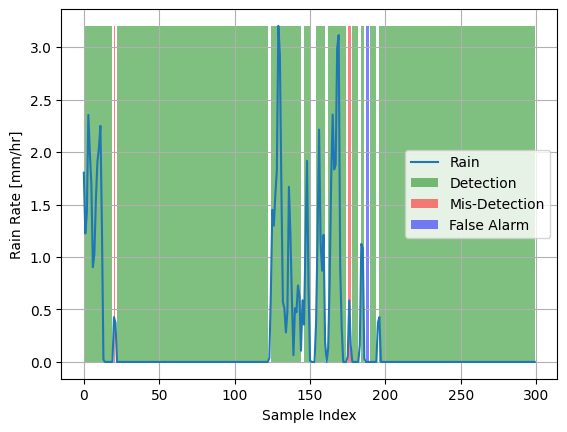

In [12]:
detection_array = np.concatenate(detection_list, axis=1)
rain_ref_array = np.concatenate(rain_ref_list, axis=1)
detection_array = np.round(detection_array)

rain_array = rain_ref_array[0, :300]
detection_array = detection_array[0, :300]
fig, ax = plt.subplots()
x = np.arange(rain_array.shape[0])
ax.plot(x, rain_array, label="Rain")
rain_max = np.max(rain_array)
ax.fill_between(x, rain_max, where=np.logical_or(np.logical_and(detection_array == 1, rain_array > 0),
                                                 np.logical_and(detection_array == 0, rain_array == 0)),
                facecolor='green', alpha=.5, label="Detection")
ax.fill_between(x, rain_max, where=np.logical_and(detection_array == 0, rain_array > 0), facecolor='red',
                alpha=.5, label="Mis-Detection")
ax.fill_between(x, rain_max, where=np.logical_and(detection_array == 1, rain_array == 0), facecolor='blue',
                alpha=.5, label="False Alarm")
plt.legend()
plt.ylabel("Rain Rate [mm/hr]")
plt.xlabel("Sample Index")
plt.grid()
plt.show()

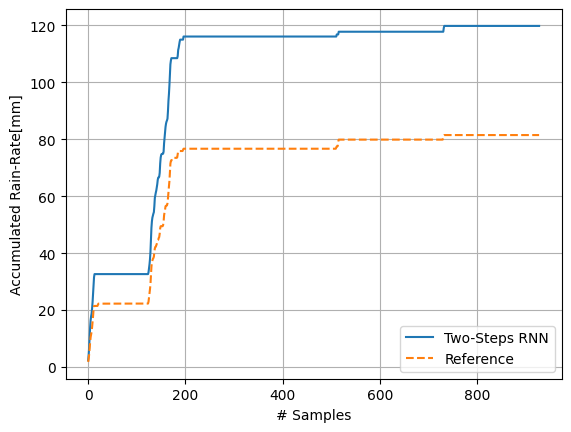

In [13]:
rain_hat_array = np.concatenate(rain_hat_list, axis=1)
rain_ref_array = np.concatenate(rain_ref_list, axis=1)

plt.plot(np.cumsum(np.maximum(rain_hat_array[0, :], 0)), label="Two-Steps RNN")
plt.plot(np.cumsum(rain_ref_array[0, :]), "--", label="Reference")
plt.grid()
plt.legend()
plt.ylabel("Accumulated Rain-Rate[mm]")
plt.xlabel("# Samples")
plt.show()

# References

[1] Habi, Hai Victor, and Hagit Messer. "Recurrent neural network for rain estimation using commercial microwave links." IEEE Transactions on Geoscience and Remote Sensing 59.5 (2020): 3672-3681. 

[2] van de Beek, Remco CZ, et al. OpenMRG: Open data from Microwave links, Radar, and Gauges for rainfall quantification in Gothenburg, Sweden. No. EGU23-14295. Copernicus Meetings, 2023.
